In [1]:
!pip install --upgrade pip
!pip install ipykernel
!pip install seaborn
!pip install pandas


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp313-cp313-win_amd64.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.2-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]
   ----------- -----

In [2]:
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.4.2
!pip install scikit-learn matplotlib

  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + C:\Users\ben\Documents\Thesis\enose-dark-sauce-classification\venv_dark_sauce\Scripts\python.exe C:\Users\ben\AppData\Local\Temp\pip-install-flc0b9qp\numpy_b515b37bf5c94d9797db26153f1ac3d5\vendored-meson\meson\meson.py setup C:\Users\ben\AppData\Local\Temp\pip-install-flc0b9qp\numpy_b515b37bf5c94d9797db26153f1ac3d5 C:\Users\ben\AppData\Local\Temp\pip-install-flc0b9qp\numpy_b515b37bf5c94d9797db26153f1ac3d5\.mesonpy-gwcbx2lv -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\ben\AppData\Local\Temp\pip-install-flc0b9qp\numpy_b515b37bf5c94d9797db26153f1ac3d5\.mesonpy-gwcbx2lv\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\ben\AppData\Local\Temp\pip-install-flc0b9qp\numpy_b515b37bf5c94d9797db26153f1ac3d5
      Build dir: C:\Users\ben\AppData\Local\T

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

In [4]:
# Training the Model

main_voc_df = pd.read_csv('final_trainingset.csv')  
X = main_voc_df.drop(columns=['Label'])
y = main_voc_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

svm_classifier = SVC(
    class_weight='balanced',
    random_state=42
)

model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None)),
    ('classifier', svm_classifier)
])

param_grid = {
    'classifier__kernel': ['rbf', 'poly'],
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10],
    'classifier__degree': [2, 3, 4],
    'pca__n_components': [2, 3],
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_



In [5]:

joblib.dump(best_model, 'svm_best_model.joblib')
print('Model saved as svm_best_model.joblib.')

Model saved as svm_best_model.joblib.


C:\Users\ben\AppData\Local\Temp\ipykernel_16580\130573307.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


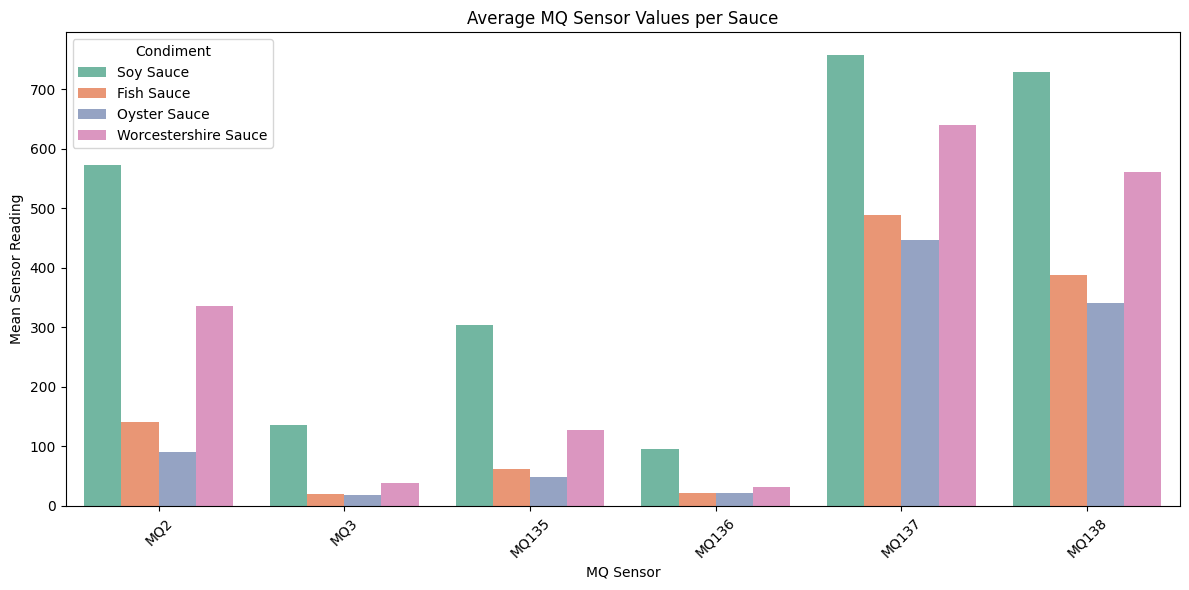

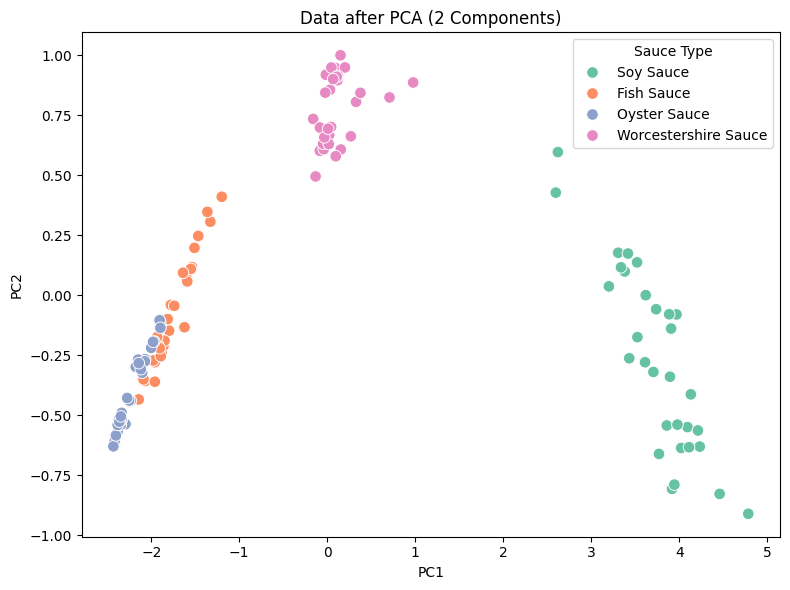

In [6]:
melted_df = main_voc_df.melt(
    id_vars="Label",
    value_vars=[col for col in main_voc_df.columns if "MQ" in col],
    var_name="Sensor",
    value_name="Value"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_df,
    x="Sensor",
    y="Value",
    hue="Label",
    ci=None,
    palette="Set2"
)

plt.title("Average MQ Sensor Values per Sauce")
plt.ylabel("Mean Sensor Reading")
plt.xlabel("MQ Sensor")
plt.xticks(rotation=45)
plt.legend(title="Condiment")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df['Label'] = y.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette="Set2", s=70)
plt.title("Data after PCA (2 Components)")
plt.legend(title="Sauce Type")
plt.tight_layout()
plt.show()


Best Hyperparameters:


,Hyperparameter,Value
0,classifier__C,0.1
1,classifier__degree,3
2,classifier__gamma,10
3,classifier__kernel,poly
4,pca__n_components,2



Evaluation Metrics (Unseen Data):


,Metric,Value
0,Accuracy,0.9500
1,Macro F1 Score,0.9500



Classification Report:
                      precision    recall  f1-score   support

           Soy Sauce       0.88      0.92      0.90        25
          Fish Sauce       0.92      0.88      0.90        25
        Oyster Sauce       1.00      1.00      1.00        25
Worcestershire Sauce       1.00      1.00      1.00        25

            accuracy                           0.95       100
           macro avg       0.95      0.95      0.95       100
        weighted avg       0.95      0.95      0.95       100



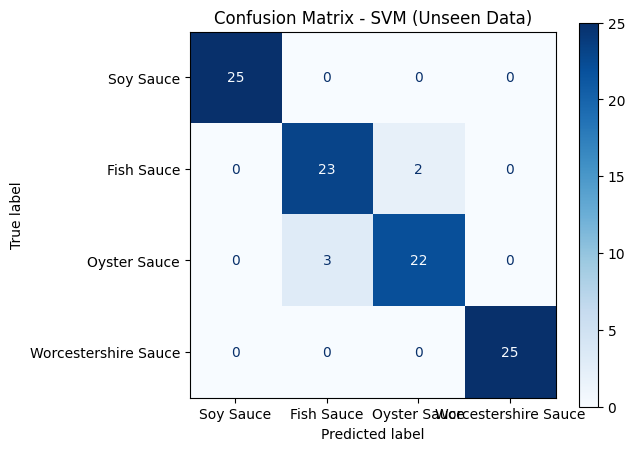


Misclassified Trials:


,True Label,Predicted Label,Correct
29,Fish Sauce,Oyster Sauce,False
30,Fish Sauce,Oyster Sauce,False
52,Oyster Sauce,Fish Sauce,False
61,Oyster Sauce,Fish Sauce,False
64,Oyster Sauce,Fish Sauce,False



All Predictions:


,True Label,Predicted Label,Correct
0,Soy Sauce,Soy Sauce,True
1,Soy Sauce,Soy Sauce,True
2,Soy Sauce,Soy Sauce,True
3,Soy Sauce,Soy Sauce,True
4,Soy Sauce,Soy Sauce,True
...,...,...,...
95,Worcestershire Sauce,Worcestershire Sauce,True
96,Worcestershire Sauce,Worcestershire Sauce,True
97,Worcestershire Sauce,Worcestershire Sauce,True
98,Worcestershire Sauce,Worcestershire Sauce,True


In [ ]:
new_df = pd.read_csv('final_trainingset.csv')
X_new = new_df.drop(columns=['Label'])
Y_new = new_df['Label']

predictions = best_model.predict(X_new)

accuracy = accuracy_score(Y_new, predictions)
f1_macro = f1_score(Y_new, predictions, average='macro')

best_params_df = pd.DataFrame(
    list(grid_search.best_params_.items()),
    columns=['Hyperparameter', 'Value']
)
print("\nBest Hyperparameters:")
display(best_params_df)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1 Score'],
    'Value': [f"{accuracy:.4f}", f"{f1_macro:.4f}"]
})
print("\nEvaluation Metrics (Unseen Data):")
display(metrics_df)

print("\nClassification Report:")
print(classification_report(Y_new, predictions, target_names=Y_new.unique()))

labels = Y_new.unique()  # Preserves label order from CSV
conf_matrix = confusion_matrix(Y_new, predictions, labels=labels)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM (Unseen Data)")
plt.tight_layout()
plt.show()


results_df = pd.DataFrame({
    'True Label': Y_new,
    'Predicted Label': predictions
})
results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

misclassified = results_df[~results_df['Correct']]

print("\nMisclassified Trials:")
display(misclassified)

print("\nAll Predictions:")
display(results_df)
#